In [5]:
# this code is needed to ensure my working directory is the same as where the dataset is
import os
os.chdir('C:\\Users\\wyman\\Desktop\\701IntroProject\\INM701')


The dataset is 1,000,000 rows but a sample size of 10000 is used to save time. However, it is stratified to maintain the same fraud ratio.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE, trustworthiness
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score

df = pd.read_csv('data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=5000, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=5000, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

This block normalizes the numeric features using StandardScaler to ensure that the GMM algorithm performs effectively. StandardScaler normalizes the data such that the Mean equals 0 and the Standard Deviation equals 1. The binary columns are left unchanged.

In [7]:
# separate features and labels
X = df.drop(columns=['fraud'], axis=1) 
y = df['fraud'] 

# separate binary columns
binary_columns = [col for col in X.columns if set(X[col].unique()) <= {0, 1}]

# separate continuous columns
continuous_columns = [col for col in X.columns if col not in binary_columns]

# scale only the continuous columns
scaler = StandardScaler()
X_scaled_continuous = scaler.fit_transform(df[continuous_columns])

# combine binary and scaled continuous data
X_scaled = pd.concat(
    [pd.DataFrame(X_scaled_continuous, columns=continuous_columns), X[binary_columns].reset_index(drop=True)],
    axis=1
)

# check that the classification labels were split properly
print("\nValue Counts for Target Labels:")
print(y.value_counts())
original_fraud_ratio = y.mean()
print(f"Fraud ratio: {original_fraud_ratio}")


Value Counts for Target Labels:
fraud
0.0    5000
1.0    5000
Name: count, dtype: int64
Fraud ratio: 0.5


### Dimensionality Reduction Functions

In [8]:
def apply_pca(X, variance_threshold): # apply PCA dimension reduction to a given dataset
    pca = PCA(n_components=variance_threshold)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

def apply_tsne(X, perplexity, learning_rate=200): # apply t-SNE dimension reduction to a given dataset
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate=learning_rate)
    X_tsne = tsne.fit_transform(X)
    return X_tsne, tsne

### Modeling Functions

In [9]:
# cross-validation function for GMM
def run_gmm_cv(X, y, n_components, covariance_type, cv=5):
    # convert to pandas objects if necessary
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    results = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        # train GMM
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
        gmm.fit(X_train)
        val_clusters = gmm.predict(X_val)
        
        # map clusters to labels based on the fraud ratios
        mapped_clusters = map_clusters_to_labels(val_clusters, y_val, original_fraud_ratio)
        
        # calculate evaluation metrics
        accuracy = accuracy_score(y_val, mapped_clusters)
        precision = precision_score(y_val, mapped_clusters, pos_label=1, zero_division=0)
        recall = recall_score(y_val, mapped_clusters, pos_label=1, zero_division=0)
        f1 = f1_score(y_val, mapped_clusters, pos_label=1, zero_division=0)
        
        results.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
        print(f"Fold Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    
    # calculate mean scores across folds
    mean_results = {metric: np.mean([res[metric] for res in results]) for metric in results[0].keys()}
    return mean_results



def grid_search_gmm(X, y, n_components_range, covariance_types, method_name="", verbose=True):
    all_results = []
    # run gmm cv for each combination of hyperparameters
    for n_components in n_components_range:
        for cov_type in covariance_types:
            score_dict = run_gmm_cv(X, y, n_components, cov_type, cv=5)
            result = {
                'Method': method_name,
                'n_components': n_components,
                'covariance_type': cov_type,
                'Accuracy': score_dict['accuracy'],
                'Precision': score_dict['precision'],
                'Recall': score_dict['recall'],
                'F1-Score': score_dict['f1']
            }
            all_results.append(result)

            if verbose:
                print(f"{method_name} - n_components: {n_components}, covariance_type: {cov_type}, "
                      f"Accuracy: {score_dict['accuracy']:.4f}, F1: {score_dict['f1']:.4f}")
    # return the dataframe containing the scores for each combination
    return pd.DataFrame(all_results)

# assigns a cluster to fraud  if the proportion of fraud cases within it 
# exceeds the dataset's overall fraud ratio 
def map_clusters_to_labels(clusters, y_val, original_fraud_ratio):
    results_df = pd.DataFrame({'Cluster': clusters, 'Actual': y_val})
    cluster_label_mapping = pd.crosstab(results_df['Cluster'], results_df['Actual'])
    cluster_to_label = {}
    for cluster in cluster_label_mapping.index:
        fraud_ratio_in_cluster = cluster_label_mapping.loc[cluster, 1.0] / cluster_label_mapping.loc[cluster].sum()
        cluster_to_label[cluster] = 1.0 if fraud_ratio_in_cluster > original_fraud_ratio else 0.0
    mapped_labels = [cluster_to_label[c] for c in clusters]
    return mapped_labels


def run_dimensionality_reduction_and_cv(X, y, method=None, n_splits=5,
                                        n_clusters=None, covariance_type='tied',
                                        pca_threshold=None, tsne_perplexity=None):    
    if method == "PCA":
        print("Applying PCA")
        X_reduced, _ = apply_pca(X, pca_threshold)
    elif method == "TSNE":
        print("Applying t-SNE")
        X_reduced, _ = apply_tsne(X, tsne_perplexity)
    elif method is None:
        print("No dimensionality reduction")
        X_reduced = X
    else:
        raise ValueError("Invalid dimensionality reduction method")

    # run  GMM cross-validation on the dimension reduced dataset
    print(f"\nRunning Cross-Validation ({'No Dimensionality Reduction' if method is None else method})")
    results = run_gmm_cv(X_reduced, y, n_clusters, covariance_type, cv=n_splits)

    # print average metrics
    print(f"Average Metrics: Accuracy: {results['accuracy']:.4f}, Precision: {results['precision']:.4f}, "
          f"Recall: {results['recall']:.4f}, F1-Score: {results['f1']:.4f}")
    
    return results

# evaluate each testing function based on a different dimension reduction using the optimal parameters
def evaluate_on_test_set(X_train, X_test, y_test, method=None,
                         pca_threshold=None, tsne_perplexity=None,
                         n_clusters=None, covariance_type=None):    
    if method == "PCA":
        # apply PCA
        X_train, pca_obj = apply_pca(X_train, pca_threshold)
        X_test = pca_obj.transform(X_test)
    elif method == "t-SNE":
        # apply t-SNE
        X_train, _ = apply_tsne(X_train, tsne_perplexity)
        X_test, _ = apply_tsne(X_test, tsne_perplexity)

    # fit GMM with the optimal parameters
    gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=42)
    gmm.fit(X_train)
    test_clusters = gmm.predict(X_test)

    mapped_test_clusters = map_clusters_to_labels(test_clusters, y_test, original_fraud_ratio)

    # calculate and print performance metrics
    accuracy = accuracy_score(y_test, mapped_test_clusters)
    precision = precision_score(y_test, mapped_test_clusters, average='binary', zero_division=0)
    recall = recall_score(y_test, mapped_test_clusters, average='binary', zero_division=0)
    f1 = f1_score(y_test, mapped_test_clusters, average='binary', zero_division=0)

    print("Performance on Test Set:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_test, mapped_test_clusters)

    return cm, X_test, test_clusters



### Graphing Functions

In [10]:
def plot_line_performance(x_values, y_values, title, xlabel, ylabel, labels=None):
    plt.figure(figsize=(10,6))
    if labels is None:
        labels = [None]*len(y_values)
    for y, lbl in zip(y_values, labels):
        plt.plot(x_values, y, marker='o', label=lbl)
    if any(labels):
        plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def plot_conf_matrix(cm, class_names=["Non-Fraud","Fraud"], title="Confusion Matrix"):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


### No Reduction Optimization

A grid search is performed to find the optimal set of hyperparameters for the model assuming the dataset has not gone through any dimension reduction.

In [11]:
# reset indices for X_scaled and y to ensure alignment
if isinstance(X_scaled, pd.DataFrame):
    X_scaled = X_scaled.reset_index(drop=True)
else:
    X_scaled = pd.DataFrame(X_scaled)

y = pd.Series(y).reset_index(drop=True)

# define GMM hyperparameter ranges
n_components_range = range(2, 6)  # number of clusters for GMM
covariance_types = ['spherical', 'diag', 'tied', 'full']  # GMM covariance types

# create an empty DataFrame to store results
no_reduction_gmm_results = pd.DataFrame(columns=['n_components', 'covariance_type', 'Silhouette_Score'])

# perform grid search for GMM on the original data (no reduction)
print("\nPerforming GMM grid search with no dimensionality reduction")

# iterate over all combinations of n_components and covariance_type
for n_clusters in n_components_range:
    for covariance_type in covariance_types:
        # train GMM to compute Silhouette Score
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=42)
        labels = gmm.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, labels)

        # print the result for the current combination
        print(f"n_components: {n_clusters}, covariance_type: {covariance_type}, Silhouette_Score: {silhouette_avg:.4f}")

        # append results to df
        no_reduction_gmm_results = pd.concat(
            [no_reduction_gmm_results, pd.DataFrame({
                'n_components': [n_clusters],
                'covariance_type': [covariance_type],
                'Silhouette_Score': [silhouette_avg]
            })],
            ignore_index=True
        )

# find the best combination of n_components and covariance_type based on Silhouette Score
best_no_reduction_result = no_reduction_gmm_results.loc[no_reduction_gmm_results['Silhouette_Score'].idxmax()]

print("\nBest No Reduction GMM Result:")
print(best_no_reduction_result)



Performing GMM grid search with no dimensionality reduction
n_components: 2, covariance_type: spherical, Silhouette_Score: 0.5509


C:\Users\wyman\AppData\Local\Temp\ipykernel_820\479451555.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  no_reduction_gmm_results = pd.concat(


n_components: 2, covariance_type: diag, Silhouette_Score: 0.2361
n_components: 2, covariance_type: tied, Silhouette_Score: 0.6815
n_components: 2, covariance_type: full, Silhouette_Score: 0.2366
n_components: 3, covariance_type: spherical, Silhouette_Score: 0.1964
n_components: 3, covariance_type: diag, Silhouette_Score: 0.1791
n_components: 3, covariance_type: tied, Silhouette_Score: 0.4629
n_components: 3, covariance_type: full, Silhouette_Score: 0.1802
n_components: 4, covariance_type: spherical, Silhouette_Score: 0.1347
n_components: 4, covariance_type: diag, Silhouette_Score: 0.1558
n_components: 4, covariance_type: tied, Silhouette_Score: 0.4778
n_components: 4, covariance_type: full, Silhouette_Score: 0.1608
n_components: 5, covariance_type: spherical, Silhouette_Score: 0.1642
n_components: 5, covariance_type: diag, Silhouette_Score: 0.0813
n_components: 5, covariance_type: tied, Silhouette_Score: 0.4946
n_components: 5, covariance_type: full, Silhouette_Score: 0.0844

Best No R

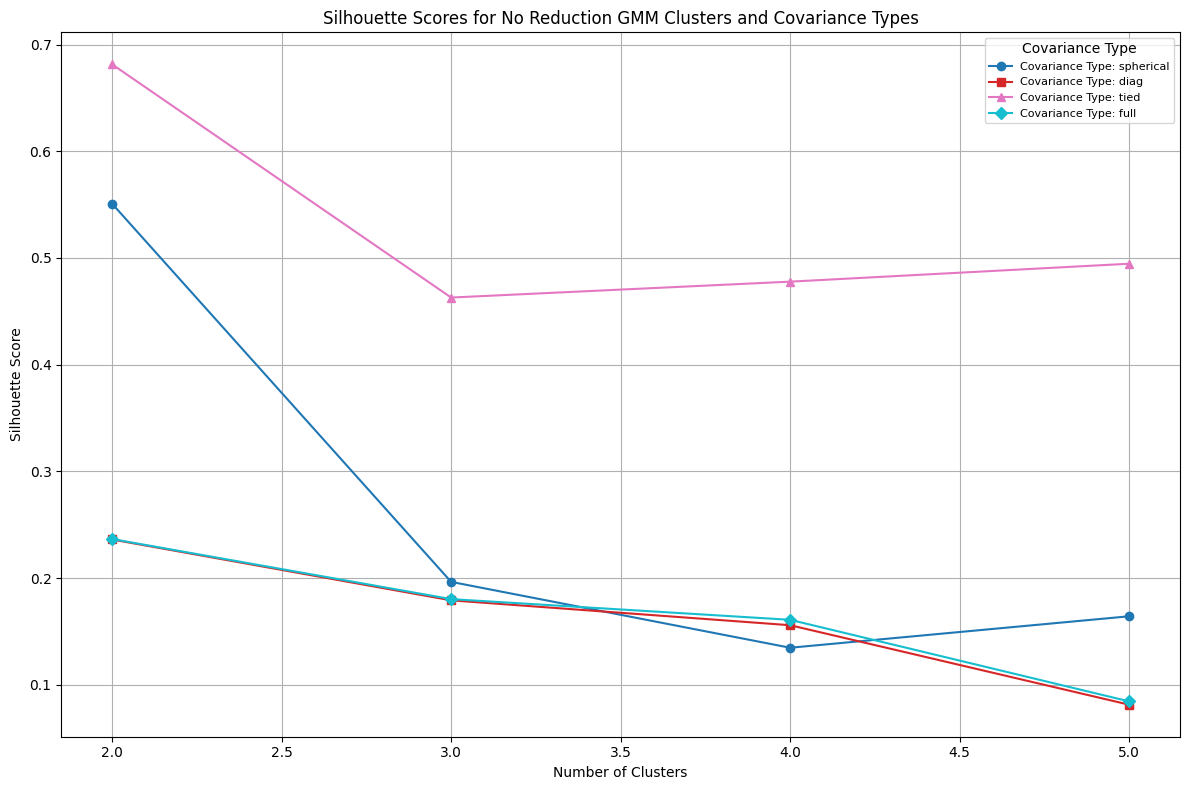

In [12]:
# visualization for No Reduction GMM Results
plt.figure(figsize=(12, 8))

# define unique markers for each covariance type
covariance_markers = {
    'spherical': 'o',  # circle
    'diag': 's',       # square
    'tied': '^',       # triangle
    'full': 'D'        # diamond
}

# assign unique colors to each covariance type
colors = plt.cm.tab10(np.linspace(0, 1, len(covariance_types)))
covariance_color_map = dict(zip(covariance_types, colors))

# loop through each covariance type
for covariance_type in covariance_types:
    # filter results for the current covariance type
    filtered_df = no_reduction_gmm_results[no_reduction_gmm_results['covariance_type'] == covariance_type]

    # extract number of clusters and silhouette scores
    n_components = filtered_df['n_components'].values
    scores = filtered_df['Silhouette_Score'].values

    plt.plot(
        n_components, scores,
        marker=covariance_markers[covariance_type],  # unique marker for covariance type
        linestyle='-', 
        color=covariance_color_map[covariance_type],  # color for each covariance type
        label=f'Covariance Type: {covariance_type}'
    )

plt.title("Silhouette Scores for No Reduction GMM Clusters and Covariance Types")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Covariance Type", fontsize=8, loc='best')
plt.grid()
plt.tight_layout()
plt.show()


As expected, performance decreases as you increase the number of clusters past 2. This makes sense because there are only 2 classes in this dataset.

### PCA Optimization

PCA is run with various combinations of retained variance thresholds, covariance types and cluster amount combinations to determine the optimal set of parameters based primarily on the silhouette score which is a value that measures how well connected the clusters are (geometric seperation). The best combination of parameters is maintained for later testing. 

In [13]:
# define PCA thresholds and RF hyperparameters
pca_thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]
n_components_range = range(2, 6)  # Number of clusters for GMM
covariance_types = ['spherical', 'diag', 'tied', 'full']  # GMM covariance types

# store results 
pca_gmm_results = pd.DataFrame(columns=['pca_threshold', 'n_components', 'covariance_type', 'Silhouette_Score'])

original_components = X_scaled.shape[1]

# loop through PCA thresholds and hyperparameter combinations
for pca_threshold in pca_thresholds:
    # apply PCA
    X_pca, pca_obj = apply_pca(X_scaled, pca_threshold)
    retained_components = pca_obj.n_components_
    removed_components = original_components - retained_components

    # perform grid search for GMM on the PCA-reduced data
    gmm_results_df = grid_search_gmm(X_pca, y, n_components_range, covariance_types, method_name="PCA-GMM", verbose=False)

    # calculate silhouette scores for each combination
    for _, row in gmm_results_df.iterrows():
        n_clusters = row['n_components']
        covariance_type = row['covariance_type']

        # train GMM to compute Silhouette Score
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=42)
        labels = gmm.fit_predict(X_pca)
        silhouette_avg = silhouette_score(X_pca, labels)

        # Print the result for the current combination
        print(f"PCA {pca_threshold} - n_components: {n_clusters}, covariance_type: {covariance_type}, Silhouette_Score: {silhouette_avg:.4f}")

        # append results to DataFrame
        pca_gmm_results = pd.concat(
            [pca_gmm_results, pd.DataFrame({
                'pca_threshold': [pca_threshold],
                'n_components': [n_clusters],
                'covariance_type': [covariance_type],
                'Silhouette_Score': [silhouette_avg]
            })],
            ignore_index=True
        )
# find the best PCA threshold, n_clusters, and covariance_type based on Silhouette Score
best_pca_result = pca_gmm_results.loc[pca_gmm_results['Silhouette_Score'].idxmax()]

print("\nBest PCA-GMM Result:")
print(best_pca_result)


Fold Metrics - Accuracy: 0.6710, Precision: 0.9071, Recall: 0.3810, F1-Score: 0.5366
Fold Metrics - Accuracy: 0.6575, Precision: 0.9028, Recall: 0.3530, F1-Score: 0.5075
Fold Metrics - Accuracy: 0.6910, Precision: 0.9189, Recall: 0.4190, F1-Score: 0.5755
Fold Metrics - Accuracy: 0.6690, Precision: 0.9311, Recall: 0.3650, F1-Score: 0.5244
Fold Metrics - Accuracy: 0.6805, Precision: 0.9020, Recall: 0.4050, F1-Score: 0.5590
Fold Metrics - Accuracy: 0.6460, Precision: 0.8395, Recall: 0.3610, F1-Score: 0.5049
Fold Metrics - Accuracy: 0.6250, Precision: 0.8238, Recall: 0.3180, F1-Score: 0.4589
Fold Metrics - Accuracy: 0.6660, Precision: 0.8547, Recall: 0.4000, F1-Score: 0.5450
Fold Metrics - Accuracy: 0.6500, Precision: 0.8788, Recall: 0.3480, F1-Score: 0.4986
Fold Metrics - Accuracy: 0.6475, Precision: 0.8214, Recall: 0.3770, F1-Score: 0.5168
Fold Metrics - Accuracy: 0.5070, Precision: 0.8889, Recall: 0.0160, F1-Score: 0.0314
Fold Metrics - Accuracy: 0.5080, Precision: 0.8333, Recall: 0.020

C:\Users\wyman\AppData\Local\Temp\ipykernel_820\2010711674.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pca_gmm_results = pd.concat(


PCA 0.7 - n_components: 2, covariance_type: diag, Silhouette_Score: 0.5125
PCA 0.7 - n_components: 2, covariance_type: tied, Silhouette_Score: 0.6793
PCA 0.7 - n_components: 2, covariance_type: full, Silhouette_Score: 0.3490
PCA 0.7 - n_components: 3, covariance_type: spherical, Silhouette_Score: 0.3169
PCA 0.7 - n_components: 3, covariance_type: diag, Silhouette_Score: 0.2362
PCA 0.7 - n_components: 3, covariance_type: tied, Silhouette_Score: 0.6925
PCA 0.7 - n_components: 3, covariance_type: full, Silhouette_Score: 0.2243
PCA 0.7 - n_components: 4, covariance_type: spherical, Silhouette_Score: 0.3994
PCA 0.7 - n_components: 4, covariance_type: diag, Silhouette_Score: 0.2692
PCA 0.7 - n_components: 4, covariance_type: tied, Silhouette_Score: 0.7051
PCA 0.7 - n_components: 4, covariance_type: full, Silhouette_Score: 0.1985
PCA 0.7 - n_components: 5, covariance_type: spherical, Silhouette_Score: 0.3805
PCA 0.7 - n_components: 5, covariance_type: diag, Silhouette_Score: 0.3105
PCA 0.7 - 

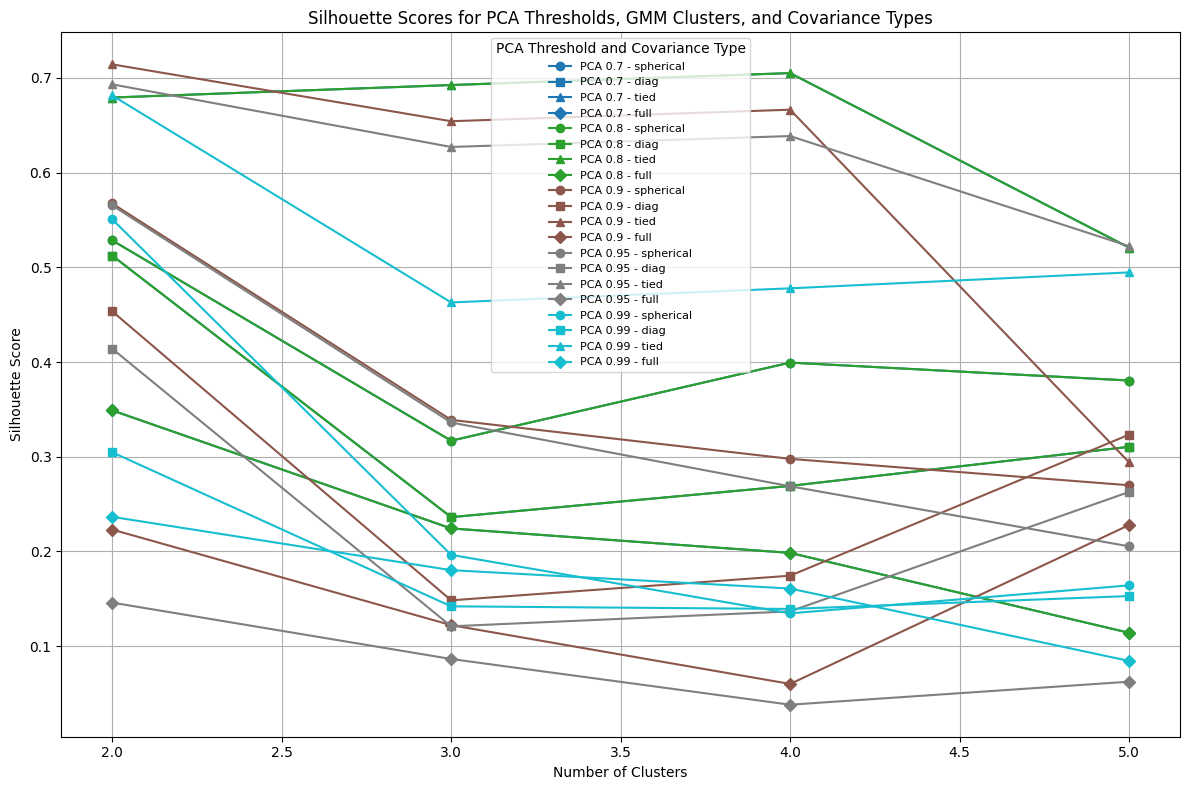

In [14]:
# visualization
plt.figure(figsize=(12, 8))

# define unique markers for each covariance type
covariance_markers = {
    'spherical': 'o',  # circle
    'diag': 's',       # square
    'tied': '^',       # triangle
    'full': 'D'        # diamond
}

# use consistent colors for each PCA threshold
colors = plt.cm.tab10(np.linspace(0, 1, len(pca_thresholds)))
threshold_color_map = dict(zip(pca_thresholds, colors))

# loop through each PCA threshold and covariance type
for threshold in pca_thresholds:
    for covariance_type in covariance_types:
        # filter the DataFrame for the current PCA threshold and covariance type
        filtered_df = pca_gmm_results[
            (pca_gmm_results['pca_threshold'] == threshold) &
            (pca_gmm_results['covariance_type'] == covariance_type)
        ]
        
        # extract number of components and silhouette scores
        n_components = filtered_df['n_components'].values
        scores = filtered_df['Silhouette_Score'].values

        # plot the scores with specific color and marker
        plt.plot(
            n_components, scores,
            marker=covariance_markers[covariance_type],  # unique marker for covariance type
            linestyle='-', 
            color=threshold_color_map[threshold],  # same color for each PCA threshold
            label=f'PCA {threshold} - {covariance_type}'
        )

plt.title("Silhouette Scores for PCA Thresholds, GMM Clusters, and Covariance Types")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="PCA Threshold and Covariance Type", fontsize=8, loc='best')
plt.grid()
plt.tight_layout()
plt.show()

The best parameters are a PCA threshold of 0.9, 2 clusters, and a tied covariance type. The silhouette score decreases as the number of clusters increases, which makes sense since the data has 2 classes (fraud and non-fraud), so each class naturally forms its own cluster. The tied covariance performs best because the fraud and non fraud clusters have similar shapes, and the tied covariance type is less prone to overfitting compared to other covariance types because it assumes all clusters share the same covariance matrix.

### t-SNE Optimization

t-SNE is run with a range of perplexities, covariance types, and cluster amount combinations to determine the optimal set of parameters based primarily on the silhouette score and the Adjusted Rand Index (ARI). The trustworthiness is useful to verify that the local structure of the data is properly reflected after the dimension reduction, but the other metrics better measure how well the data is preservered after being reduced. ARI is used for t-SNE and not PCA because ARI evaluates cluster alignment with true labels and t-SNE tries to preserve local similarities in data, unlike PCA which has to preserve linearity. t-SNE doesn't always prefer 2 clusters. I think this is because this method always reduces the data to 2 dimensions (compared to PCA which is variable) which can substantially alter the way the data is preserved, causing the model to recognize more clusters.

In [15]:
# define t-SNE perplexities and GMM hyperparameter ranges
tsne_perplexities = [5, 10, 20, 30, 40]
n_components_range = range(2, 6)  # Number of clusters for GMM
covariance_types = ['spherical', 'diag', 'tied', 'full']  # GMM covariance types

# create an empty DataFrame to store results
tsne_gmm_results = pd.DataFrame(columns=[
    'tsne_perplexity', 'n_components', 'covariance_type', 'Silhouette_Score', 'ARI', 'Trustworthiness'
])

# loop through t-SNE perplexities
for perplexity in tsne_perplexities:
    # apply t-SNE
    print(f"\nApplying t-SNE with Perplexity: {perplexity}")
    X_tsne, tsne_obj = apply_tsne(X_scaled, perplexity, learning_rate=200)

    # calculate trustworthiness for the reduced data
    trust = trustworthiness(X_scaled, X_tsne, n_neighbors=5)
    print(f"Trustworthiness: {trust:.4f}")

    # perform GMM grid search on the t-SNE-reduced data
    gmm_results_df = grid_search_gmm(X_tsne, y, n_components_range, covariance_types, method_name=f"t-SNE-{perplexity}", verbose=False)

    # calculate silhouette and ARI scores for each GMM combination
    for _, row in gmm_results_df.iterrows():
        n_clusters = row['n_components']
        covariance_type = row['covariance_type']

        # fit GMM and compute performance metrics
        gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, random_state=42)
        labels = gmm.fit_predict(X_tsne)
        silhouette_avg = silhouette_score(X_tsne, labels)
        ari_score = adjusted_rand_score(y, labels)

        # print the result for the current combination
        print(f"t-SNE {perplexity} - n_components: {n_clusters}, covariance_type: {covariance_type}, "
              f"Silhouette_Score: {silhouette_avg:.4f}, ARI: {ari_score:.4f}")

        #append results to df
        tsne_gmm_results = pd.concat([
            tsne_gmm_results,
            pd.DataFrame([{
                'tsne_perplexity': perplexity,
                'n_components': n_clusters,
                'covariance_type': covariance_type,
                'Silhouette_Score': silhouette_avg,
                'ARI': ari_score,
                'Trustworthiness': trust
            }])
        ], ignore_index=True)

# find the best t-SNE configuration based on ARI and silhouette score
best_tsne_result = tsne_gmm_results.sort_values(['ARI', 'Silhouette_Score'], ascending=[False, False]).iloc[0]
print(f"\nBest t-SNE Result:\n{best_tsne_result}")



Applying t-SNE with Perplexity: 5
Trustworthiness: 0.9996
Fold Metrics - Accuracy: 0.7840, Precision: 0.7817, Recall: 0.7880, F1-Score: 0.7849
Fold Metrics - Accuracy: 0.6700, Precision: 0.6625, Recall: 0.6930, F1-Score: 0.6774
Fold Metrics - Accuracy: 0.7265, Precision: 0.7276, Recall: 0.7240, F1-Score: 0.7258
Fold Metrics - Accuracy: 0.7340, Precision: 0.7505, Recall: 0.7010, F1-Score: 0.7249
Fold Metrics - Accuracy: 0.6955, Precision: 0.6930, Recall: 0.7020, F1-Score: 0.6975
Fold Metrics - Accuracy: 0.6790, Precision: 0.6769, Recall: 0.6850, F1-Score: 0.6809
Fold Metrics - Accuracy: 0.7175, Precision: 0.7122, Recall: 0.7300, F1-Score: 0.7210
Fold Metrics - Accuracy: 0.7195, Precision: 0.7167, Recall: 0.7260, F1-Score: 0.7213
Fold Metrics - Accuracy: 0.7280, Precision: 0.7360, Recall: 0.7110, F1-Score: 0.7233
Fold Metrics - Accuracy: 0.7040, Precision: 0.7082, Recall: 0.6940, F1-Score: 0.7010
Fold Metrics - Accuracy: 0.7840, Precision: 0.7874, Recall: 0.7780, F1-Score: 0.7827
Fold M

C:\Users\wyman\AppData\Local\Temp\ipykernel_820\2115314955.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsne_gmm_results = pd.concat([


t-SNE 5 - n_components: 2, covariance_type: diag, Silhouette_Score: 0.3266, ARI: 0.1169
t-SNE 5 - n_components: 2, covariance_type: tied, Silhouette_Score: 0.3269, ARI: 0.1972
t-SNE 5 - n_components: 2, covariance_type: full, Silhouette_Score: 0.3268, ARI: 0.1999
t-SNE 5 - n_components: 3, covariance_type: spherical, Silhouette_Score: 0.3656, ARI: 0.2626
t-SNE 5 - n_components: 3, covariance_type: diag, Silhouette_Score: 0.3599, ARI: 0.2423
t-SNE 5 - n_components: 3, covariance_type: tied, Silhouette_Score: 0.3649, ARI: 0.2699
t-SNE 5 - n_components: 3, covariance_type: full, Silhouette_Score: 0.3656, ARI: 0.2597
t-SNE 5 - n_components: 4, covariance_type: spherical, Silhouette_Score: 0.3514, ARI: 0.2067
t-SNE 5 - n_components: 4, covariance_type: diag, Silhouette_Score: 0.3502, ARI: 0.2020
t-SNE 5 - n_components: 4, covariance_type: tied, Silhouette_Score: 0.3507, ARI: 0.2139
t-SNE 5 - n_components: 4, covariance_type: full, Silhouette_Score: 0.3514, ARI: 0.2085
t-SNE 5 - n_components

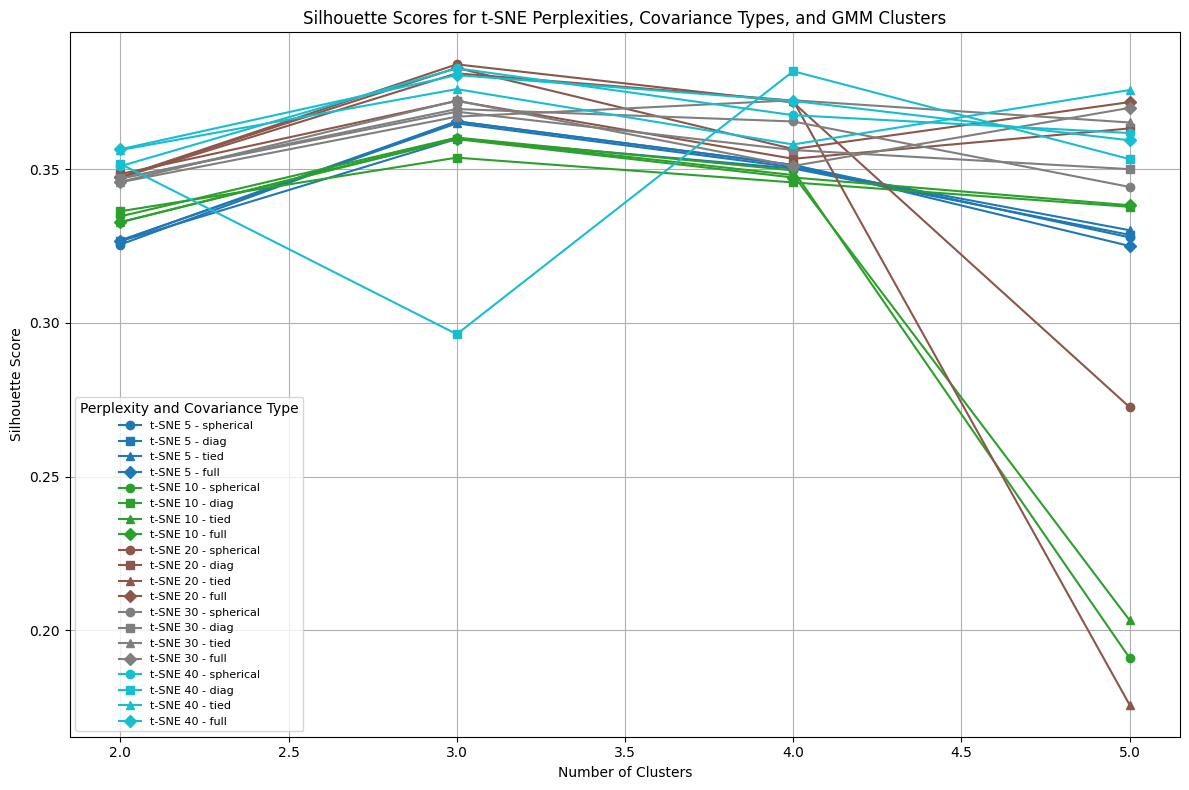

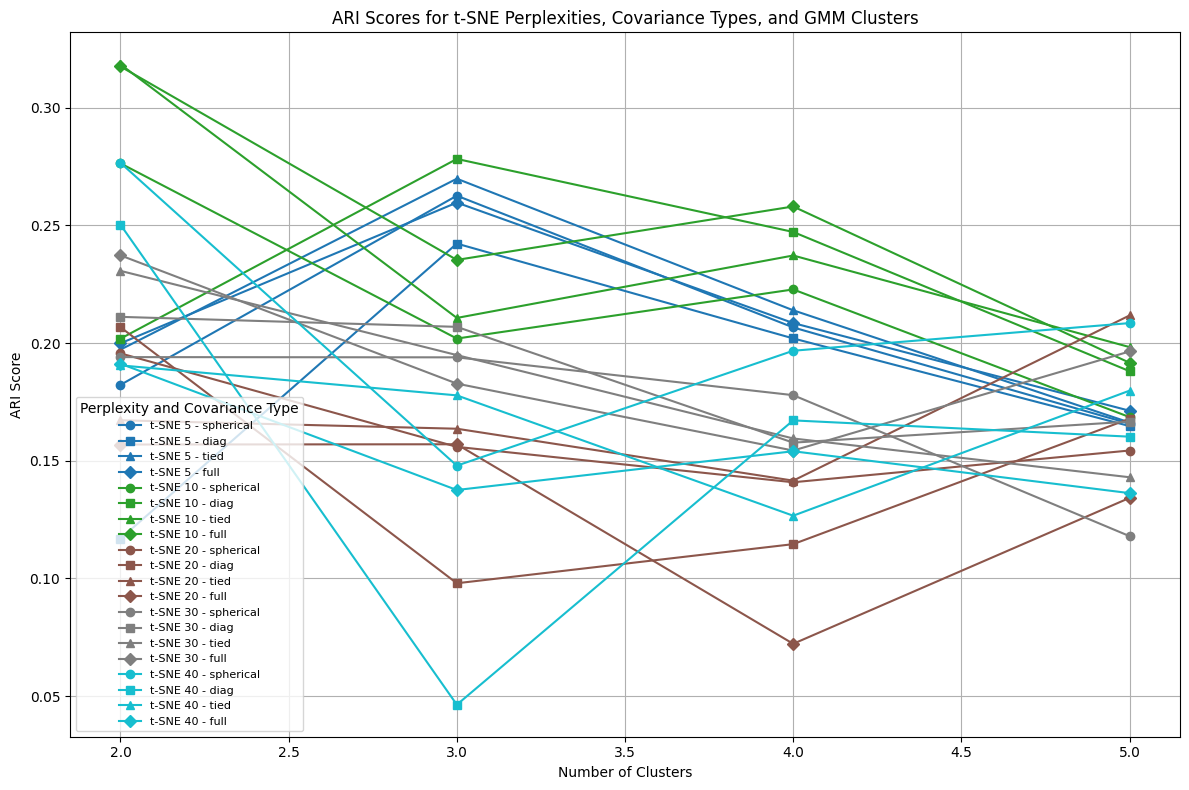

In [16]:
plt.figure(figsize=(12, 8))

# define unique markers for covariance types
covariance_markers = {
    'spherical': 'o',
    'diag': 's',
    'tied': '^',
    'full': 'D'
}

# use consistent colors for each t-SNE perplexity
colors = plt.cm.tab10(np.linspace(0, 1, len(tsne_perplexities)))
perplexity_color_map = dict(zip(tsne_perplexities, colors))

# loop through each t-SNE perplexity and covariance type
for perplexity in tsne_perplexities:
    for covariance_type in covariance_types:
        # filter df for the current perplexity and covariance type
        filtered_df = tsne_gmm_results[
            (tsne_gmm_results['tsne_perplexity'] == perplexity) &
            (tsne_gmm_results['covariance_type'] == covariance_type)
        ]

        # extract clusters and silhouette scores
        n_components = filtered_df['n_components'].values
        scores = filtered_df['Silhouette_Score'].values

        plt.plot(
            n_components, scores,
            marker=covariance_markers[covariance_type],
            linestyle='-', color=perplexity_color_map[perplexity],
            label=f't-SNE {perplexity} - {covariance_type}'
        )

plt.title("Silhouette Scores for t-SNE Perplexities, Covariance Types, and GMM Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Perplexity and Covariance Type", fontsize=8, loc='best')
plt.grid()
plt.tight_layout()
plt.show()

# plot for ARI Score
plt.figure(figsize=(12, 8))

# loop through each t-SNE perplexity and covariance type for ARI Score
for perplexity in tsne_perplexities:
    for covariance_type in covariance_types:
        filtered_df = tsne_gmm_results[
            (tsne_gmm_results['tsne_perplexity'] == perplexity) &
            (tsne_gmm_results['covariance_type'] == covariance_type)
        ]

        # extract clusters and ARI Scores
        n_components = filtered_df['n_components'].values
        scores = filtered_df['ARI'].values

        plt.plot(
            n_components, scores,
            marker=covariance_markers[covariance_type],
            linestyle='-', color=perplexity_color_map[perplexity],
            label=f't-SNE {perplexity} - {covariance_type}'
        )

plt.title("ARI Scores for t-SNE Perplexities, Covariance Types, and GMM Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("ARI Score")
plt.legend(title="Perplexity and Covariance Type", fontsize=8, loc='best')
plt.grid()
plt.tight_layout()
plt.show()


There does not seem to be a correlation between the different parameters for the silhouette score, besides the performance steadily decreasing as the amount of clusters increase. The ARI score significantly decreases as the number of clusters increase. Additionally, the ARI score goes down as the perplexity increases, likely because higher perplexity values causes clusters to spread out and overlap more which can reduce their alignment with the true class labels.

### Final Trained Parameters
This block aggregates the best hyperparameters for each dataset and prints them to summarize information.

In [17]:
# extract and store the best hyperparameters for No Reduction
print("\nUsing the best hyperparameters for No Reduction")
best_no_reduction_n_components = best_no_reduction_result['n_components']
best_no_reduction_covariance_type = best_no_reduction_result['covariance_type']

# extract and store the best hyperparameters for PCA
print("\nUsing the best hyperparameters for PCA")
best_pca_threshold = best_pca_result['pca_threshold']
best_pca_n_components = best_pca_result['n_components']
best_pca_covariance_type = best_pca_result['covariance_type']

# extract and store the best hyperparameters for t-SNE
print("\nUsing the best hyperparameters for t-SNE")
best_tsne_perplexity = best_tsne_result['tsne_perplexity']
best_tsne_n_components = best_tsne_result['n_components']
best_tsne_covariance_type = best_tsne_result['covariance_type']

# print the recap of the best hyperparameters
print("\nBest GMM results for No Reduction:")
print(f"Best n_components: {best_no_reduction_n_components}")
print(f"Best covariance_type: {best_no_reduction_covariance_type}")

print("\nBest GMM results for PCA:")
print(f"Best PCA Threshold: {best_pca_threshold}")
print(f"Best n_components: {best_pca_n_components}")
print(f"Best covariance_type: {best_pca_covariance_type}")

print("\nBest GMM results for t-SNE:")
print(f"Best t-SNE Perplexity: {best_tsne_perplexity}")
print(f"Best n_components: {best_tsne_n_components}")
print(f"Best covariance_type: {best_tsne_covariance_type}")



Using the best hyperparameters for No Reduction

Using the best hyperparameters for PCA

Using the best hyperparameters for t-SNE

Best GMM results for No Reduction:
Best n_components: 2
Best covariance_type: tied

Best GMM results for PCA:
Best PCA Threshold: 0.9
Best n_components: 2
Best covariance_type: tied

Best GMM results for t-SNE:
Best t-SNE Perplexity: 10
Best n_components: 2
Best covariance_type: tied


### Validation Metrics

This block runs cross validation to test the performance metrics with each form of dimension reduction.


Running No Dimensionality Reduction
No dimensionality reduction

Running Cross-Validation (No Dimensionality Reduction)
Fold Metrics - Accuracy: 0.5155, Precision: 0.9429, Recall: 0.0330, F1-Score: 0.0638
Fold Metrics - Accuracy: 0.5080, Precision: 0.8333, Recall: 0.0200, F1-Score: 0.0391
Fold Metrics - Accuracy: 0.5145, Precision: 0.8919, Recall: 0.0330, F1-Score: 0.0636
Fold Metrics - Accuracy: 0.5080, Precision: 1.0000, Recall: 0.0160, F1-Score: 0.0315
Fold Metrics - Accuracy: 0.5135, Precision: 0.8000, Recall: 0.0360, F1-Score: 0.0689
Average Metrics: Accuracy: 0.5119, Precision: 0.8936, Recall: 0.0276, F1-Score: 0.0534
Processed Metrics for No Dimensionality Reduction: [np.float64(0.5119), np.float64(0.8936164736164736), np.float64(0.027600000000000003), 0.0]

Running PCA
Applying PCA

Running Cross-Validation (PCA)
Fold Metrics - Accuracy: 0.5070, Precision: 0.8889, Recall: 0.0160, F1-Score: 0.0314
Fold Metrics - Accuracy: 0.5080, Precision: 0.8333, Recall: 0.0200, F1-Score: 0.0

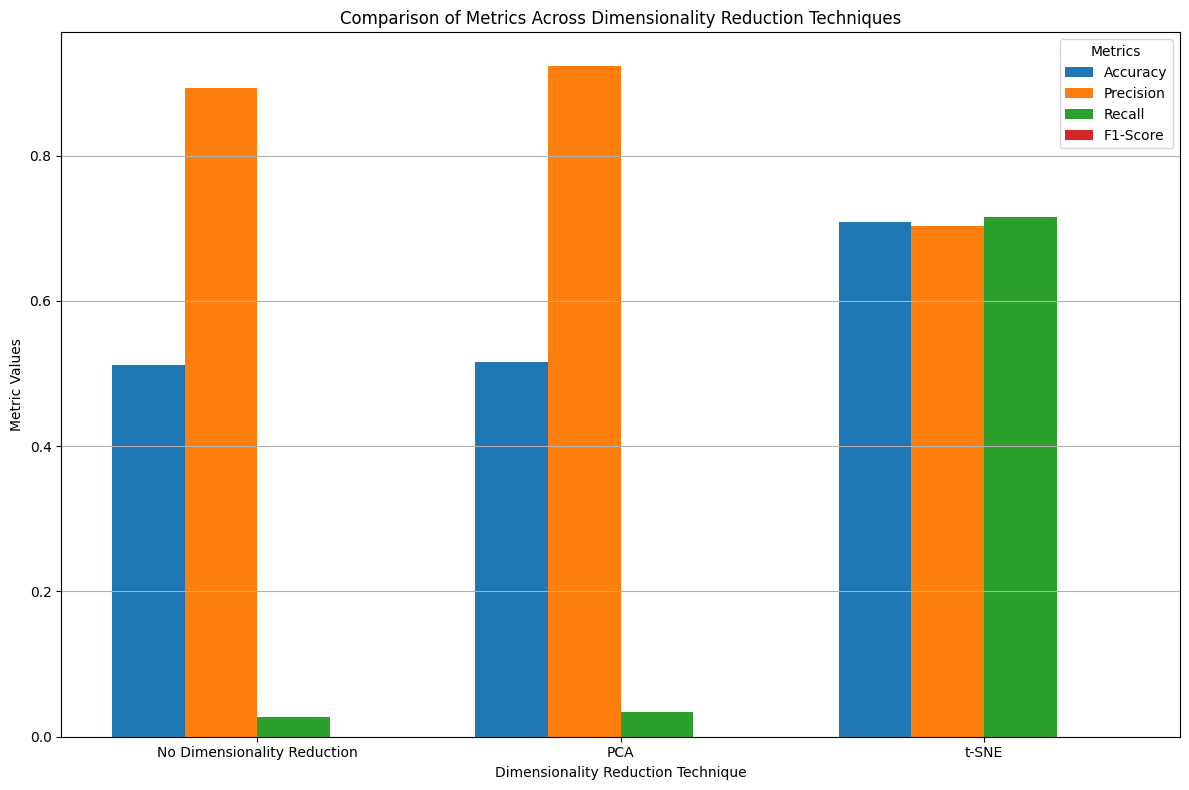

In [18]:
# Parameter configurations for each method
method_configs = {
    "No Dimensionality Reduction": {
        "method": None,
        "n_clusters": best_no_reduction_n_components,
        "covariance_type": best_no_reduction_covariance_type
    },
    "PCA": {
        "method": "PCA",
        "n_clusters": best_pca_n_components,
        "covariance_type": best_pca_covariance_type,
        "pca_threshold": best_pca_threshold
    },
    "t-SNE": {
        "method": "TSNE",
        "n_clusters": best_tsne_n_components,
        "covariance_type": best_tsne_covariance_type,
        "tsne_perplexity": best_tsne_perplexity
    }
}

# Collect metrics for each method
methods = list(method_configs.keys())
metrics_labels = ["Accuracy", "Precision", "Recall", "F1-Score"]
metrics_list = []

for method_name, config in method_configs.items():
    print(f"\nRunning {method_name}")
    metrics = run_dimensionality_reduction_and_cv(
        X_scaled, y,
        method=config.get("method"),
        n_clusters=config.get("n_clusters"),
        covariance_type=config.get("covariance_type"),
        pca_threshold=config.get("pca_threshold"),
        tsne_perplexity=config.get("tsne_perplexity")
    )

    # Ensure metrics are a list of numeric values
    if isinstance(metrics, dict):
        metrics = [metrics.get(label.lower(), 0.0) for label in metrics_labels]
    elif not isinstance(metrics, (list, tuple)):
        raise ValueError(f"Invalid metrics format for {method_name}: {metrics}")

    print(f"Processed Metrics for {method_name}: {metrics}")
    metrics_list.append(metrics)

# Convert metrics_list to a NumPy array for visualization
scores = np.array(metrics_list)

# Ensure scores are numeric
if np.any(scores == None):
    raise ValueError("Scores array contains None values. Check input metrics.")

# Define the data for plotting
x = np.arange(len(methods))
width = 0.2  

plt.figure(figsize=(12, 8))
for i, metric_label in enumerate(metrics_labels):
    plt.bar(x + i * width, scores[:, i], width, label=metric_label)

plt.title("Comparison of Metrics Across Dimensionality Reduction Techniques")
plt.ylabel("Metric Values")
plt.xlabel("Dimensionality Reduction Technique")
plt.xticks(x + width * 1.5, methods)
plt.legend(title="Metrics")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


No Reduction and PCA demonstrate a very high precision value but a low recall and F-1 score. This is because the model seems to only be guessing positive when it is extremely sure, leading to a high precision, but this high standard causes the model to overlook other positive cases, which leads to the low recall and F1. t-SNE seems to improve the all metrics because it makes a wider range of predictions.

The following block evaluates the test set after it has been trained on models using data altered by either PCA, t-SNE, or no dimension reduction.


Evaluating No Dimensionality Reduction
Performance on Test Set:
Accuracy: 0.5103
Precision: 0.8298
Recall: 0.0260
F1-Score: 0.0504

Evaluating PCA
Performance on Test Set:
Accuracy: 0.5263
Precision: 0.9438
Recall: 0.0560
F1-Score: 0.1057

Evaluating t-SNE
Performance on Test Set:
Accuracy: 0.5063
Precision: 0.5063
Recall: 0.5073
F1-Score: 0.5068


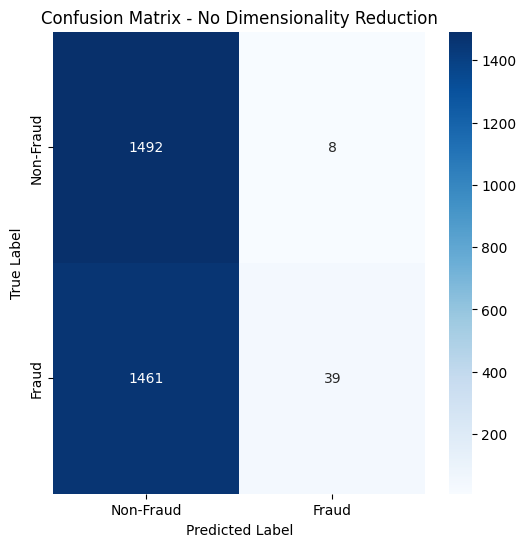

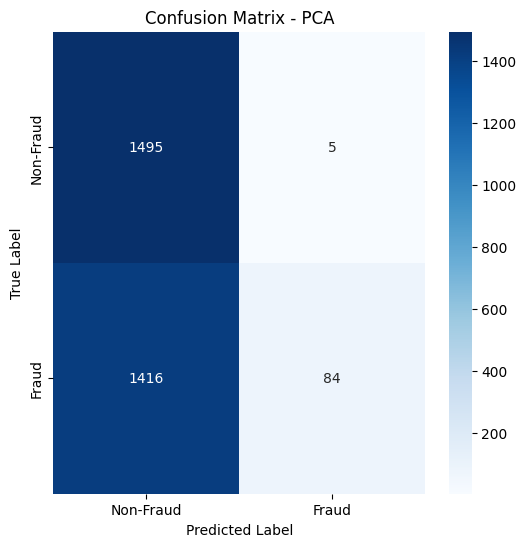

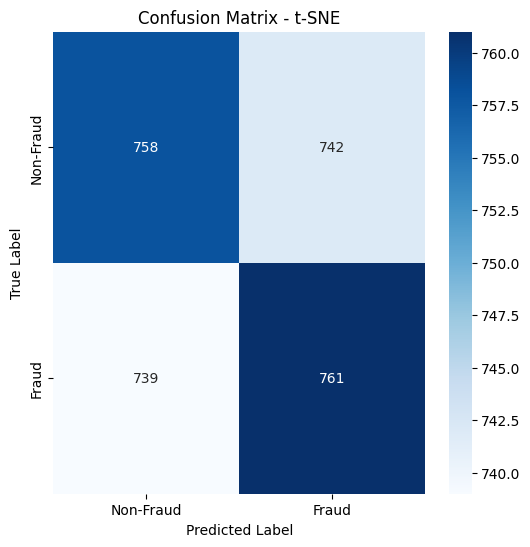

In [19]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

method_configs = {
    "No Dimensionality Reduction": {
        "method": None,
        "best_result": best_no_reduction_result
    },
    "PCA": {
        "method": "PCA",
        "best_result": best_pca_result,
        "threshold_key": "pca_threshold"
    },
    "t-SNE": {
        "method": "t-SNE",
        "best_result": best_tsne_result,
        "perplexity_key": "tsne_perplexity"
    }
}

# initialize dictionaries to store evaluation results
test_conf_matrices = {}
reduced_test_sets = {}
test_clusters_results = {}

# evaluate each method
for method_name, config in method_configs.items():
    print(f"\nEvaluating {method_name}")
    method = config["method"]
    best_result = config["best_result"]
    n_clusters = int(best_result["n_components"])
    covariance_type = best_result["covariance_type"]

    if method == "PCA":
        pca_threshold = best_result[config["threshold_key"]]
        cm, X_test_reduced, test_clusters = evaluate_on_test_set(
            X_train, X_test, y_test,
            method="PCA",
            pca_threshold=pca_threshold,
            n_clusters=n_clusters,
            covariance_type=covariance_type
        )
        reduced_test_sets[method_name] = X_test_reduced
        test_clusters_results[method_name] = test_clusters

    elif method == "t-SNE":
        tsne_perplexity = best_result[config["perplexity_key"]]
        cm, X_test_reduced, test_clusters = evaluate_on_test_set(
            X_train, X_test, y_test,
            method="t-SNE",
            tsne_perplexity=tsne_perplexity,
            n_clusters=n_clusters,
            covariance_type=covariance_type
        )
        reduced_test_sets[method_name] = X_test_reduced
        test_clusters_results[method_name] = test_clusters

    else:  
        cm, _, _ = evaluate_on_test_set(
            X_train, X_test, y_test,
            method=None,
            n_clusters=n_clusters,
            covariance_type=covariance_type
        )

    test_conf_matrices[method_name] = cm  

# generate heatmaps for the confusion matrices
for method_name, cm in test_conf_matrices.items():
    plot_conf_matrix(cm, title=f"Confusion Matrix - {method_name}")


### Dimensional Reduction Analysis
The confusion matrices for each of the reduction techniques provides valuable insight into how dimension reduction affects performance. Without any reduction, the model achieves a high number of true negatives (1492) but misses almost all fraud cases, with 1461 cases incorrectly predicted as non-fraud (false negatives). It also only has 8 false positives, meaning it is only predicting fraud very cautiously. The PCA reduced dataset very similarly, with a high number of true negatives (1495) and a low number of false positives (5). It slightly improves recall by identifying 84 True positives but it still misses a vast majority of fraud causes with 1416 false negatives. This suggests PCA struggles to differentiate fraud in the reduced feature space. t-SNE's confusion matrix is more balanced, predicting each outcome almost equally. This lack of reliability can make it very difficult to apply to real world applications like fraud detection. 

### Cluster Analysis
The following block graphs the clusters in unique colors, with a seperate hollow red triange symbol that highlights the fraud causes.

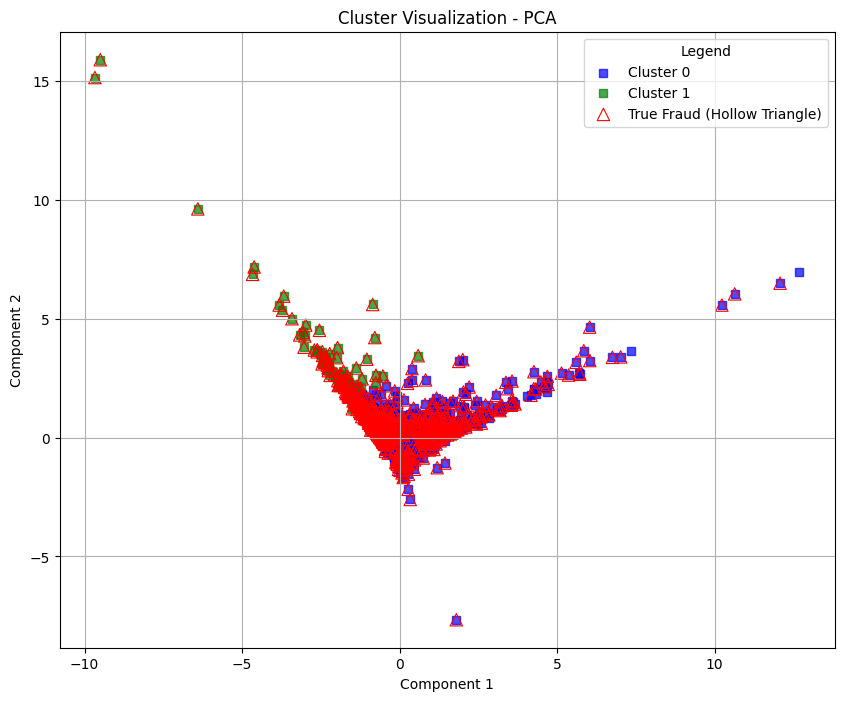

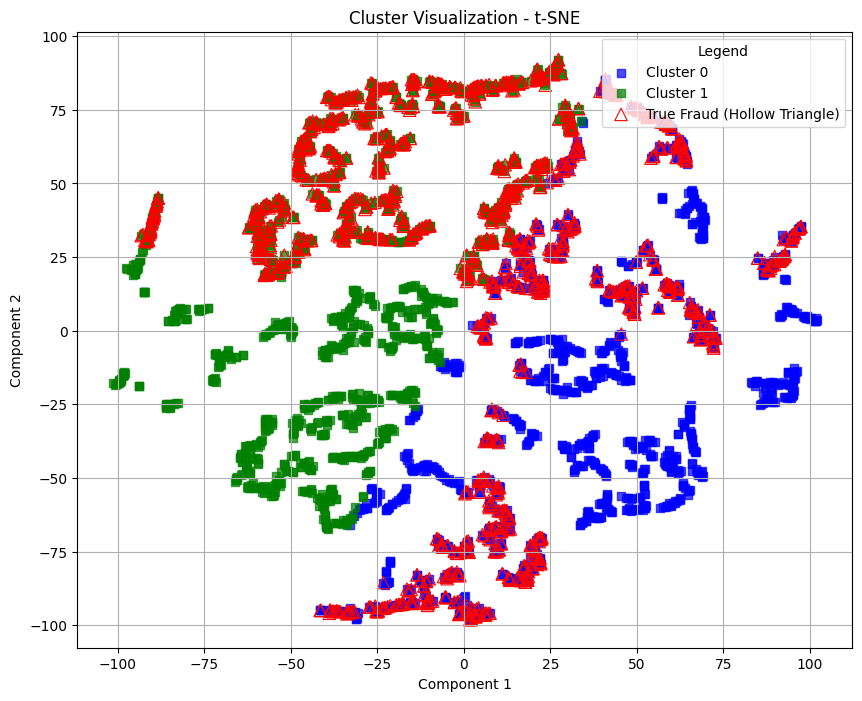

In [20]:
# function to plot clusters dynamically for any number of clusters
def plot_clusters(X_test_transformed, y_test, clusters, method_name):
    plt.figure(figsize=(10, 8))

    # define a distinct color palette for clusters (excluding red)
    cluster_colors = ['blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'pink', 'gray']
    unique_clusters = np.unique(clusters)

    if len(unique_clusters) > len(cluster_colors):
        raise ValueError("Too many clusters for the predefined color palette. Add more colors if needed.")

    # plot each cluster with a distinct color
    for i, cluster in enumerate(unique_clusters):
        cluster_indices = (clusters == cluster)
        plt.scatter(
            X_test_transformed[cluster_indices, 0],
            X_test_transformed[cluster_indices, 1],
            c=cluster_colors[i],
            marker='s',
            label=f"Cluster {cluster}",
            alpha=0.7
        )

    # overlay true fraud cases (y_test == 1) as hollow red triangles
    true_fraud_indices = (y_test == 1).values
    plt.scatter(
        X_test_transformed[true_fraud_indices, 0],
        X_test_transformed[true_fraud_indices, 1],
        edgecolor='red',
        facecolor="none",
        marker='^',
        linewidths=0.8,
        s=80,
        label="True Fraud (Hollow Triangle)"
    )

    plt.title(f"Cluster Visualization - {method_name}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Legend", loc="upper right")
    plt.grid(True)
    plt.show()

# graph clusters for PCA and t-SNE
for method in ["PCA", "t-SNE"]:
    if method in reduced_test_sets:
        plot_clusters(
            reduced_test_sets[method],
            y_test,
            test_clusters_results[method],
            method_name=method
        )

The clusters are visualized on each of the graphs, one with a PCA reduction and the other with t-SNE. In each graph, the fraudulent  data points (red hollow triangles) don't seem to correlate with any of the other clusters, instead they are distributed almost randomly throughout the existing clusters. This fact, combined with the lack of reliable testing results after many forms of preprocessing leads me to believe that the GMM model is not well suited for this classification problem.